# Computer System

Computer system consists of several key components:

* A processor, also referred to as CPU which is able to execute the programs we give it (in addition to running an operating system and many other things), typically consisting of 8 or more cores.
* Memory (RAM) to store and retrieve the results from computation, such as weight vectors, activations, often training data.
* An Ethernet network connection (sometimes multiple) with speeds ranging from 1Gbit/s to 100Gbit/s (on high end servers more advanced interconnects can be found).
* A high speed expansion bus (PCIe) to connect the system to one or more GPUs. Severs have up to 8 accelerators, often connected in an advanced topology, desktop systems have 1-2, depending on the budget of the user and the size of the power supply.
* Durable storage, such as a magnetic harddrive (HDD), solid state (SSD), in many cases connected using the PCIe bus, provides efficient transfer of training data to the system and storage of intermediate checkpoints as needed.

![Connectivity of components](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/mobo-symbol.svg)


As the diagram indicates, most components (network, GPU, storage) are connected to the CPU across the PCI Express bus. It consists of multiple lanes that are directly attached to the CPU. For instance AMD's Threadripper 3 has 64 PCIe 4.0 lanes, each of which is capable 16 Gbit/s data transfer in both directions. The memory is directly attached to the CPU with a total bandwidth of up to 100 GB/s.

When we run code on a computer we need to shuffle data to the processors (CPU or GPU), perform computation and then move the results off the processor back to RAM and durable storage. Hence, in order to get good performance we need to make sure that this works seamlessly without any one of the systems becoming a major bottleneck. For instance, if we cannot load images quickly enough the processor will not have any work to do. Likewise, if we cannot move matrices quickly enough to the CPU (or GPU), its processing elements will starve. Finally, if we want to synchronize multiple computers across the network, the latter should not slow down computation. One option is to interleave communication and computation. Let us have a look at the various components in more detail.

## Memory

At its most basic memory is used to store data that needs to be readily accessible. At present CPU RAM is typically of the [DDR4](https://en.wikipedia.org/wiki/DDR4_SDRAM) variety, offering 20-25GB/s bandwidth per module. Each module has a 64 bit wide bus. Typically pairs of memory modules are used to allow for multiple channels. CPUs have between 2 and 4 memory channels, i.e., they have between 40GB/s and 100GB/s peak memory bandwidth. Often there are two banks per channel. For instance AMD's Zen 3 Threadripper has 8 slots.

While these numbers are impressive, indeed, they only tell part of the story. When we want to read a portion from memory we first need to tell the memory module where the information can be found. That is, we first need to send the *address* to RAM. Once this accomplished we can choose to read just a single 64bit record or a long sequence of records. The latter is called *burst read*. In a nutshell, sending an address to memory and setting up the transfer takes approximately 100ns (details depend on the specific timing coefficients of the memory chips used), every subsequent transfer takes only 0.2ns. In short, the first read is 500 times as expensive as subsequent ones! We could perform up to $10,000,000$ random reads per second. This suggests that we avoid random memory access as far as possible and use burst reads (and writes) instead.

Matters are a bit more complex when we take into account that we have multiple banks. Each bank can read memory largely independently. This means two things: the effective number of random reads is up to 4x higher, provided that they are spread evenly across memory. It also means that it is still a bad idea to perform random reads since burst reads are 4x faster, too. Secondly, due to memory alignment to 64 bit boundaries it is a good idea to align any datastructures with the same boundaries. Compilers do this pretty much [automatically](https://en.wikipedia.org/wiki/Data_structure_alignment) when the appropriate flags are set. [Zeshan Chishti's slides](http://web.cecs.pdx.edu/~zeshan/ece585_lec5.pdf).

GPU memory is subject to even higher bandwidth requirements since they have many more processing elements than CPUs. By and large there are two options to address them. One is to make the memory bus significantly wider. For instance NVIDIA's RTX 2080 Ti has a 352 bit wide bus. This allows for much more information to be transferred at the same time. Secondly, GPUs use specific high-performance memory. Consumer grade devices, such as NVIDIA's RTX and Titan series typically use [GDDR6](https://en.wikipedia.org/wiki/GDDR6_SDRAM) chips with over 500 GB/s aggregate bandwidth. An alternative is to use HBM (high bandwidth memory) modules. They use a very different interface and connect directly with GPUs on a dedicated silicon wafer. This makes them very expensive and their use is typically limited to high end server chips, such as the NVIDIA Volta V100 series of accelerators. Quite unsurprisingly GPU memory is *much* smaller than CPU memory due to its higher cost. For our purposes, by and large their performance characteristics are similar, just a lot faster. We can safely ignore the details for the purpose of this book. They only matter when tuning GPU kernels for high throughput.

## Storage

We saw that some of the key characteristics of RAM were *bandwidth* and *latency*. The same is true for storage devices, just that the differences can be even more extreme.

**Hard Disks** have been in use for over half a century. In a nutshell they contain a number of spinning platters with heads that can be positioned to read / write at any given track. High end end disks hold up to 16TB on 9 platters. One of the key benefits of HDDs is that they are relatively inexpensive. One of their many downsides are their typically catastrophic failure modes and their relatively high read latency.

To understand the latter, consider the fact that HDDs spin at around 7,200 RPM. If they were much faster they would shatter due to the centrifugal force exerted on the platters. This has a major downside when it comes to accessing a specific sector on the disk: we need to wait until the platter has rotated in position (we can move the heads but not accelerate the actual disks). Hence it can take over 8ms until the requested data is available. A common way this is expressed is to say that HDDs can operate at approximately 100 IOPs. This number has essentially remained unchanged for the past two decades. Worse still, it is equally difficult to increase bandwidth (it is in the order of 100-200 MB/s). After all, each head reads a track of bits, hence the bit rate only scales with the square root of the information density. As a result HDDs are quickly becoming relegated to archival storage and low-grade storage for very large datasets.

**Solid State Drives** use Flash memory to store information persistently. This allows for *much faster* access to stored records. Modern SSDs can operate at 100,000 to 500,000 IOPs, i.e., up to 3 orders of magnitude faster than HDDs. Furthermore, their bandwidth can reach 1-3GB/s, i.e., one order of magnitude faster than HDDs. These improvements sound almost too good to be true. Indeed, they come with a number of caveats, due to the way SSDs are designed.

* SSDs store information in blocks (256 KB or larger). They can only be written as a whole, which takes significant time. Consequently bit-wise random writes on SSD have very poor performance. Likewise, writing data in general takes significant time since the block has to be read, erased and then rewritten with new information. By now SSD controllers and firmware have developed algorithms to mitigate this. Nonetheless writes can be much slower, in particular for QLC (quad level cell) SSDs. The key for improved performance is to maintain a *queue* of operations, to prefer reads and to write in large blocks if possible.
* The memory cells in SSDs wear out relatively quickly (often already after a few thousand writes). Wear-level protection algorithms are able to spread the degradation over many cells. That said, it is not recommended to use SSDs for swap files or for large aggregations of log-files.
* Lastly, the massive increase in bandwidth has forced computer designers to attach SSDs directly to the PCIe bus. The drives capable of handling this, referred to as NVMe (Non Volatile Memory enhanced), can use up to 4 PCIe lanes. This amounts to up to 8GB/s on PCIe 4.0.

**Cloud Storage** provides a configurable range of performance. That is, the assignment of storage to virtual machines is dynamic, both in terms of quantity and in terms speed, as chosen by the user. We recommend that the user increase the provisioned number of IOPs whenever latency is too high, e.g., during training with many small records.

## CPUs

Central Processing Units (CPUs) are the centerpiece of any computer. They consist of a number of key components: processor cores which are able to execute machine code, a bus connecting them (the specific topology differs significantly between processor models, generations and vendors), and caches to allow for higher bandwidth and lower latency memory access than what is possible by reads from main memory. Lastly, almost all modern CPUs contain vector processing units to aid with high performance linear algebra and convolutions, as they are common in media processing and machine learning.

![Intel Skylake consumer quad-core CPU](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/skylake.svg)

This figure depicts an Intel Skylake consumer grade quad-core CPU. It has an integrated GPU, caches, and a ringbus connecting the four cores. Peripherals (Ethernet, WiFi, Bluetooth, SSD controller, USB, etc.) are either part of the chipset or directly attached (PCIe) to the CPU.

### Microarchitecture

Each of the processor cores consists of a rather sophisticated set of components. While details differ between generations and vendors, the basic functionality is pretty much standard. The front end loads instructions and tries to predict which path will be taken (e.g., for control flow). Instructions are then decoded from assembly code to microinstructions. Assembly code is often not the lowest level code that a processor executes. Instead, complex instructions may be decoded into a set of more lower level operations. These are then processed by the actual execution core. Often the latter is capable of performing many operations simultaneously. For instance, the ARM Cortex A77 core of :numref:`fig_cortexa77` is able to perform up to 8 operations simultaneously.

![ARM Cortex A77 Microarchitecture Overview](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/a77.svg)
:label:`fig_cortexa77`

This means that efficient programs might be able to perform more than one instruction per clock cycle, *provided that* they can be carried out independently. Not all units are created equal. Some specialize in integer instructions whereas others are optimized for floating point performcne. To increase throughput the processor might also follow  multiple codepaths simultaneously in a branching instruction and then discard the results of the branch not taken. This is why branch prediction units matter (on the frontend) such that only the most promising paths are pursued.

### Vectorization

Deep learning is extremely compute hungry. Hence, to make CPUs suitable for machine learning one needs to perform many operations in one clock cycle. This is achieved via vector units. They have different names: on ARM they are called NEON, on x86 the latest generation is referred to as [AVX2](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) units. A common aspect is that they are able to perform SIMD (single instruction multiple data) operations. :numref:`fig_neon128` shows how 8 short integers can be added in one clock cycle on ARM.

![128 bit NEON vectorization](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/neon128.svg)
:label:`fig_neon128`

Depending on architecture choices such registers are up to 512 bit long, allowing for the combination of up to 64 pairs of numbers. For instance, we might be multiplying two numbers and adding them to a third, which is also known as a fused multiply-add. Intel's [OpenVino](https://01.org/openvinotoolkit) uses these to achieve respectable throughput for deep learning on server grade CPUs.

### Cache

Consider the following situation: we have a modest CPU core with 4 cores as depicted in :numref:`fig_skylake` above, running at 2GHz frequency. Moreover, let us assume that we have an IPC (instructions per clock) count of 1 and that the units have AVX2 with 256bit width enabled. Let us furthermore assume that at least one of the registers used for AVX2 operations needs to be retrieved from memory. This means that the CPU consumes 4x256bit = 1kbit of data per clock cycle. Unless we are able to transfer $2 \cdot 10^9 \cdot 128 = 256 \cdot 10^9$ bytes to the processor per second the processing elements are going to starve. Unfortunately the memory interface of such a chip only supports 20-40 GB/s data transfer, i.e., one order of magnitude less. The fix is to avoid loading *new* data from memory as far as possible and rather to cache it locally on the CPU. This is where caches come in handy (see this [Wikipedia article](https://en.wikipedia.org/wiki/Cache_hierarchy) for a primer). Commonly the following names / concepts are used:

* **Registers** are strictly speaking not part of the cache. They help stage instructions. That said, CPU registers are memory locations that a CPU can access at clock speed without any delay penalty. CPUs have tens of registers. It is up to the compiler (or programmer) to use registers efficiently. For instance the C programming language has a `register` keyword.
* **L1** caches are the first line of defense against high memory bandwidth requirements. L1 caches are tiny (typical sizes might be 32-64kB) and often split into data and instructions caches. When data is found in the L1 cache access is very fast. If it cannot be found there, the search progresses down the cache hierarchy.
* **L2** caches are the next stop. Depending on architecture design and processor size they might be exclusive. They might be accessible only by a given core or shared between multiple cores. L2 caches are larger (typically 256-512kB per core) and slower than L1. Furthermore, to access something in L2 we first need to check to realize that the data is not in L1, which adds a small amount of extra latency.
* **L3** caches are shared between multiple cores and can be quite large. AMD's Epyc 3 server CPUs have a whopping 256MB of cache spread across multiple chiplets. More typical numbers are in the 4-8MB range.

Predicting which memory elements will be needed next is one of the key optimization parameters in chip design. For instance, it is advisable to traverse memory in a *forward* direction since most caching algorithms will try to *read ahead* rather than backwards. Likewise, keeping memory access patterns local is agood way of improving performance.
Adding caches is a double-edge sword. On one hand they ensure that the processor cores do not starve of data. At the same time they increase chip size, using up area that otherwise could have been spent on increasing processing power. Moreover, *cache misses* can be expensive. Consider the worst case scenario, depicted in :numref:`fig_falsesharing`. A memory location is cached on processor 0 when a thread on processor 1 requests the data. To obtain it, processor 0 needs to stop what it is doing, write the information back to main memory and then let processor 1 read it from memory. During this operation both processors wait. Quite potentially such code runs *more slowly* on multiple processors when compared to an efficient single-processor implementation. This is one more reason for why there is a practical limit to cache sizes (besides their physical size).

![False sharing (image courtesy of Intel)](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/falsesharing.svg)
:label:`fig_falsesharing`

## GPUs and other Accelerators


Adding vector units to a processor core allowed us to increase throughput significantly (in the example in the figure we were able to perform 16 operations simultaneously). What if we added operations that optimized not just operations between vectors but also between matrices? This strategy led to Tensor Cores (more on this shortly). Secondly, what if we added many more cores? In a nutshell, these two strategies summarize the design decisions in GPUs. :numref:`fig_turing_processing_block` gives an overview over a basic processing block. It contains 16 integer and 16 floating point units. In addition to that, two Tensor Cores accelerate a narrow subset of additional operations relevant for deep learning. Each Streaming Multiprocessor (SM) consists of four such blocks.

![NVIDIA Turing Processing Block (image courtesy of NVIDIA)](https://github.com/d2l-ai/d2l-en/blob/master/img/turing-processing-block.png?raw=true)
:width:`150px`
:label:`fig_turing_processing_block`

12 streaming multiprocessors are then grouped into graphics processing clusters which make up the high-end TU102 processors. Ample memory channels and an L2 cache complement the setup. :numref:`fig_turing` has the relevant details. One of the reasons for designing such a device is that individual blocks can be added or removed as needed to allow for more compact chips and to deal with yield issues (faulty modules might not be activated). Fortunately programming such devices is well hidden from the casual deep learning researcher beneath layers of CUDA and framework code. In particular, more than one of the programs might well be executed simultaneously on the GPU, provided that there are available resources. Nonetheless it pays to be aware of the limitations of the devices to avoid picking models that do not fit into device memory.

![NVIDIA Turing Architecture (image courtesy of NVIDIA)](https://github.com/d2l-ai/d2l-en/blob/master/img/turing.png?raw=true)
:width:`350px`

A last aspect that is worth mentioning in more detail are TensorCores. They are an example of a recent trend of adding more optimized circuits that are specifically effective for deep learning. For instance, the TPU added a systolic array :cite:`Kung.1988` for fast matrix multiplication. There the design was to support a very small number (one for the first generation of TPUs) of large operations. TensorCores are at the other end. They are optimized for small operations involving between 4x4 and 16x16 matrices, depending on their numerical precision. :numref:`fig_tensorcore` gives an overview of the optimizations.

![NVIDIA TensorCores in Turing (image courtesy of NVIDIA)](https://github.com/d2l-ai/d2l-en/blob/master/img/tensorcore.jpg?raw=true)
:width:`400px`
:label:`fig_tensorcore`

Obviously when optimizing for computation we end up making certain compromises. One of them is that GPUs are not very good at handling interrupts and sparse data. While there are notable exceptions, such as [Gunrock](https://github.com/gunrock/gunrock) :cite:`Wang.Davidson.Pan.ea.2016`, the access pattern of sparse matrices and vectors do not go well with the high bandwidth burst read operations where GPUs excel. Matching both goals is an area of active research.


## Networks and Buses


* **PCIe** is a dedicated bus for very high bandwidth point to point connections (up to 16 Gbs on PCIe 4.0) per lane. Latency is in the order of single-digit microseconds (5 μs). PCIe links are precious. Processors only have a limited number of them: AMD's EPYC 3 has 128 lanes, Intel's Xeon has up to 48 lanes per chip; on desktop grade CPUs the numbers are 20 (Ryzen 9) and 16 (Core i9) respectively. Since GPUs have typically 16 lanes this limits the number of GPUs that can connect to the CPU at full bandwidth. After all, they need to share the links with other high bandwidth peripherals such as storage and Ethernet. Just like with RAM access, large bulk transfers are preferable due to reduced packet overhead.
* **Ethernet** is the most commonly used way of connecting computers. While it is significantly slower than PCIe, it is very cheap and resilient to install and covers much longer distances. Typical bandwidth for low-grade servers is 1 GBit/s. Higher end devices (e.g., [C5 instances](https://aws.amazon.com/ec2/instance-types/c5/) in the cloud) offer between 10 and 100 GBit/s bandwidth. As in all previous cases data transmission has significant overheads. Note that we almost never use raw Ethernet directly but rather a protocol that is executed on top of the physical interconnect (such as UDP or TCP/IP). This adds further overhead. Like PCIe, Ethernet is designed to connect two devices, e.g., a computer and a switch.
* **Switches** allow us to connect multiple devices in a manner where any pair of them can carry out a (typically full bandwidth) point to point connection simultaneously. For instance, Ethernet switches might connect 40 servers at high cross-sectional bandwidth. Note that switches are not unique to traditional computer networks. Even PCIe lanes can be [switched](https://www.broadcom.com/products/pcie-switches-bridges/pcie-switches). This occurs e.g., to connect a large number of GPUs to a host processor, as is the case for the [P2 instances](https://aws.amazon.com/ec2/instance-types/p2/).
* **NVLink** is an alternative to PCIe when it comes to very high bandwidth interconnects. It offers up to 300 Gbit/s data transfer rate per link. Server GPUs (Volta V100) have 6 links whereas consumer grade GPUs (RTX 2080 Ti) have only one link, operating at a reduced 100 Gbit/s rate. We recommend to use [NCCL](https://github.com/NVIDIA/nccl) to achieve high data transfer between GPUs.

## Summary

* Devices have overheads for operations. Hence it is important to aim for a small number of large transfers rather than many small ones. This applies to RAM, SSDs, Networks and GPUs.
* Vectorization is key for performance. Make sure you are aware of the specific abilities of your accelerator. E.g., some Intel Xeon CPUs are particularly good for INT8 operations, NVIDIA Volta GPUs excel at FP16 matrix-matrix operations and NVIDIA Turing shines at FP16, INT8 and INT4 operations.
* Numerical overflow due to small datatypes can be a problem during training (and to a lesser extent during inference).
* Aliasing can significantly degrade performance. For instance, memory alignment on 64 bit CPUs should be done with respect to 64 bit boundaries. On GPUs it is a good idea to keep convolution sizes aligned e.g., to TensorCores.
* Match your algorithms to the hardware (memory footprint, bandwidth, etc.). Great speedup (orders of magnitude) can be achieved when fitting the parameters into caches.
* We recommend that you sketch out the performance of a novel algorithm on paper before verifying the experimental results. Discrepancies of an order-of-magnitude or more are reasons for concern.
* Use profilers to debug performance bottlenecks.
* Training and inference hardware have different sweet spots in terms of price / performance.

## More Latency Numbers

The summary in :numref:`table_latency_numbers` and :numref:`table_latency_numbers_tesla` are due to [Eliot Eshelman](https://gist.github.com/eshelman) who maintains an updated version of the numbers as a [GitHub Gist](https://gist.github.com/eshelman/343a1c46cb3fba142c1afdcdeec17646).

:Common Latency Numbers.

| Action | Time | Notes |
| :----------------------------------------- | -----: | :---------------------------------------------- |
| L1 cache reference/hit                     | 1.5 ns | 4 cycles                                        |
| Floating-point add/mult/FMA                | 1.5 ns | 4 cycles                                        |
| L2 cache reference/hit                     |   5 ns | 12 ~ 17 cycles                                  |
| Branch mispredict                          |   6 ns | 15 ~ 20 cycles                                  |
| L3 cache hit (unshared cache)              |  16 ns | 42 cycles                                       |
| L3 cache hit (shared in another core)      |  25 ns | 65 cycles                                       |
| Mutex lock/unlock                          |  25 ns |                                                 |
| L3 cache hit (modified in another core)    |  29 ns | 75 cycles                                       |
| L3 cache hit (on a remote CPU socket)      |  40 ns | 100 ~ 300 cycles (40 ~ 116 ns)                  |
| QPI hop to a another CPU (per hop)         |  40 ns |                                                 |
| 64MB memory ref. (local CPU)          |  46 ns | TinyMemBench on Broadwell E5-2690v4             |
| 64MB memory ref. (remote CPU)         |  70 ns | TinyMemBench on Broadwell E5-2690v4             |
| 256MB memory ref. (local CPU)         |  75 ns | TinyMemBench on Broadwell E5-2690v4             |
| Intel Optane random write                  |  94 ns | UCSD Non-Volatile Systems Lab                   |
| 256MB memory ref. (remote CPU)        | 120 ns | TinyMemBench on Broadwell E5-2690v4             |
| Intel Optane random read                   | 305 ns | UCSD Non-Volatile Systems Lab                   |
| Send 4KB over 100 Gbps HPC fabric          |   1 μs | MVAPICH2 over Intel Omni-Path                   |
| Compress 1KB with Google Snappy            |   3 μs |                                                 |
| Send 4KB over 10 Gbps ethernet             |  10 μs |                                                 |
| Write 4KB randomly to NVMe SSD             |  30 μs | DC P3608 NVMe SSD (QOS 99% is 500μs)            |
| Transfer 1MB to/from NVLink GPU            |  30 μs | ~33GB/s on NVIDIA 40GB NVLink                 |
| Transfer 1MB to/from PCI-E GPU             |  80 μs | ~12GB/s on PCIe 3.0 x16 link                  |
| Read 4KB randomly from NVMe SSD            | 120 μs | DC P3608 NVMe SSD (QOS 99%)                     |
| Read 1MB sequentially from NVMe SSD        | 208 μs | ~4.8GB/s DC P3608 NVMe SSD                    |
| Write 4KB randomly to SATA SSD             | 500 μs | DC S3510 SATA SSD (QOS 99.9%)                   |
| Read 4KB randomly from SATA SSD            | 500 μs | DC S3510 SATA SSD (QOS 99.9%)                   |
| Round trip within same datacenter          | 500 μs | One-way ping is ~250μs                          |
| Read 1MB sequentially from SATA SSD        |   2 ms | ~550MB/s DC S3510 SATA SSD                    |
| Read 1MB sequentially from disk            |   5 ms | ~200MB/s server HDD                           |
| Random Disk Access (seek+rotation)         |  10 ms |                                                 |
| Send packet CA->Netherlands->CA            | 150 ms |                                                 |
:label:`table_latency_numbers`

:Latency Numbers for NVIDIA Tesla GPUs.

| Action | Time | Notes |
| :------------------------------ | -----: | :---------------------------------------- |
| GPU Shared Memory access        |  30 ns | 30~90 cycles (bank conflicts add latency) |
| GPU Global Memory access        | 200 ns | 200~800 cycles                            |
| Launch CUDA kernel on GPU       |  10 μs | Host CPU instructs GPU to start kernel    |
| Transfer 1MB to/from NVLink GPU |  30 μs | ~33GB/s on NVIDIA 40GB NVLink           |
| Transfer 1MB to/from PCI-E GPU  |  80 μs | ~12GB/s on PCI-Express x16 link         |
:label:`table_latency_numbers_tesla`



# Linux Tools for Computer System

## CPU Information

### cpuinfo

A typical general-purpose CPU has hardware units to perform arithmetics on integers (called [ALU](https://en.wikipedia.org/wiki/Arithmetic_logic_unit)) and floating-points (called [FPU](https://en.wikipedia.org/wiki/Floating-point_unit)). The performance of various data types depends on the hardware.

In [ ]:
# The following code runs on Linux
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.222
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4400.44
clflush size	: 64
cache_alignment	: 64
addres

To get a little specific, you can employ the grep command – a CLI tool for searching plain-text data for lines matching a regular expression. This can help you only output vendor name, model name, number of processors, number of cores, etc:

In [ ]:
# The following code runs on Linux
!cat /proc/cpuinfo | grep "model name" | head -1

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!cat /proc/cpuinfo | grep 'vendor' | uniq		#view vendor name

vendor_id	: GenuineIntel


In [ ]:
!cat /proc/cpuinfo | grep 'model name' | uniq		#display model name

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!cat /proc/cpuinfo | grep processor | wc -l		#count the number of processing units

2


In [ ]:
!cat /proc/cpuinfo | grep 'core id'			#show individual cores

core id		: 0
core id		: 0


### lscpu

lscpu Command – Shows CPU Architecture Info

In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4400.44
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

### arch & uname

If all you need to know is the architecture of your CPU, you can use the arch command:

In [ ]:
!arch

x86_64


The uname command is usually used to print information about your kernel. Because your kernel is highly dependent on your CPU, you can extract a lot of CPU data from its output. For example, you can get the vendor of your CPU with the --hardware-platform (-i for short) option:

In [ ]:
!uname

Linux


In [ ]:
!uname --hardware-platform

x86_64


You can also get the model of your CPU with the --processor (-p for short) option:

In [ ]:
!uname --processor

x86_64


the architecture with --machine (-m):

In [ ]:
!uname --machine

x86_64


### cpuid

The command cpuid dumps complete information about the CPU(s) collected from the CPUID instruction, and also discover the exact model of x86 CPU(s) from that information.

In [ ]:
!apt install cpuid

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  cpuid
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 104 kB of archives.
After this operation, 443 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cpuid amd64 20211210-1 [104 kB]
Fetched 104 kB in 1s (171 kB/s)
Selecting previously unselected package cpuid.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../cpuid_20211210-1_amd64.deb ...
Unpacking cpuid (20211210-1) ...
Setting up cpuid (20211210-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!cpuid

CPU 0:
   vendor_id = "GenuineIntel"
   version information (1/eax):
      processor type  = primary processor (0)
      family          = 0x6 (6)
      model           = 0xf (15)
      stepping id     = 0x0 (0)
      extended family = 0x0 (0)
      extended model  = 0x4 (4)
      (family synth)  = 0x6 (6)
      (model synth)   = 0x4f (79)
      (simple synth)  = Intel Core (unknown type) (Broadwell-E / Broadwell-EX) {Haswell}, 14nm
   miscellaneous (1/ebx):
      process local APIC physical ID = 0x0 (0)
      maximum IDs for CPUs in pkg    = 0x2 (2)
      CLFLUSH line size              = 0x8 (8)
      brand index                    = 0x0 (0)
   brand id = 0x00 (0): unknown
   feature information (1/edx):
      x87 FPU on chip                        = true
      VME: virtual-8086 mode enhancement     = true
      DE: debugging extensions               = true
      PSE: page size extensions              = true
      TSC: time stamp counter                = true
      RDMSR and WRMSR sup

### inxi

Inxi is a powerful command-line system information script intended for both console and IRC (Internet Relay Chat). You can use it to instantly retrieve hardware information.

In [ ]:
!sudo apt install inxi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  bind9-dnsutils bind9-host bind9-libs dmidecode dnsutils libfontenc1 liblmdb0
  libmaxminddb0 libpci3 libxkbfile1 libxtst6 libxxf86dga1 lm-sensors
  mesa-utils mesa-utils-bin pci.ids pciutils tree usbutils x11-utils
  x11-xserver-utils
Suggested packages:
  libxml-dumper-perl mmdb-bin fancontrol read-edid i2c-tools nickle cairo-5c
  xorg-docs-core
The following NEW packages will be installed:
  bind9-dnsutils bind9-host bind9-libs dmidecode dnsutils inxi libfontenc1
  liblmdb0 libmaxminddb0 libpci3 libxkbfile1 libxtst6 libxxf86dga1 lm-sensors
  mesa-utils mesa-utils-bin pci.ids pciutils tree usbutils x11-utils
  x11-xserver-utils
0 upgraded, 22 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,057 kB of archives.
After this operation, 12.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jamm

To display complete CPU information, including per CPU clock-speed and CPU max speed (if available), use the -C flag as follows:

In [ ]:
!inxi -C

CPU:
  Info: single core model: Intel Xeon bits: 64 type: MT cache: L2: 256 KiB
  Speed (MHz): avg: 2200 min/max: N/A cores: 1: 2200 2: 2200


### hardinfo

hardinfo displays hardware information in a GTK+ window, you can install it as follows:

In [ ]:
!sudo apt install hardinfo 	#Debian/Ubuntu systems

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  librsvg2-common
Suggested packages:
  gvfs
The following NEW packages will be installed:
  hardinfo libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  librsvg2-common
0 upgraded, 7 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,684 kB of archives.
After this operation, 8,127 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 hardinfo amd64 0.5.1+git20180227-2.1build1 [349 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:5 ht

Once you have it installed, type:

In [ ]:
!hardinfo

Computer
 Summary
Error: unable to open display 
xdpyinfo:  unable to open display "".
 Operating System
 Kernel Modules
 Boots
 Languages
 Filesystems
 Display
 Environment Variables
 Development
 Users
 Groups
Devices
 Processor
 Memory
 PCI Devices
lspci: Unable to load libkmod resources: error -2
 USB Devices
 Printers
 Battery
 Sensors
 Input Devices
 Storage
 DMI
 Memory SPD
 Resources
Network
 Interfaces
 IP Connections
 Routing Table
 ARP Table
 DNS Servers
 Statistics
 Shared Directories
Benchmarks
 CPU Blowfish
^C


### nproc & ps

nproc command is used to show the number of processing unit present on your computer:

In [ ]:
!nproc

2


Check Top Processes sorted by RAM or CPU Usage in Linux

In [ ]:
!ps -eo pid,ppid,cmd,%mem,%cpu --sort=-%mem | head

    PID    PPID CMD                         %MEM %CPU
   1780    1770 node /datalab/web/pyright/p  0.9  1.1
     85       7 /usr/bin/python3 /usr/local  0.8  0.4
   1714      85 /usr/bin/python3 -m colab_k  0.8  0.8
     63       7 python3 /usr/local/bin/cola  0.3  0.0
      7       1 /tools/node/bin/node /datal  0.3  0.3
   1770       7 /usr/colab/bin/language_ser  0.1  0.0
   1745       1 /usr/bin/python3 /usr/local  0.1  0.1
     21      19 /usr/colab/bin/kernel_manag  0.0  0.0
     86       7 /usr/local/bin/dap_multiple  0.0  0.0


The -o (or –format) option of ps allows you to specify the output format. A favorite of mine is to show the processes’ PIDs (pid), PPIDs (pid), the name of the executable file associated with the process (cmd), and the RAM and CPU utilization (%mem and %cpu, respectively).

Additionally, I use --sort to sort by either %mem or %cpu. By default, the output will be sorted in ascendant form, but personally I prefer to reverse that order by adding a minus sign in front of the sort criteria.

To add other fields to the output, or change the sort criteria, refer to the OUTPUT FORMAT CONTROL section in the man page of ps command.

### SIZE_MAX in C++

This code checks SIZE_MAX to determine the potential maximum size of a variable. If it's set to 64-bit, then the CPU that compiled the code is capable of 64-bit.

In [ ]:
%%writefile checkcpu.cpp
#include <iostream>
using namespace std;

int main() {
    if ( SIZE_MAX == 0xFFFFFFFF ) {
      std::cout << "32 bit";
    } else if ( SIZE_MAX == 0xFFFFFFFFFFFFFFFF ) {
      std::cout << "64 bit";
    } else {
      std::cout << "Unknown";
    }
    //std::cout << "Welcome To Colab\n";
    return 0;
}

Overwriting checkcpu.cpp


In [ ]:
%%bash

g++ checkcpu.cpp -o checkcpu
./checkcpu

64 bit

## CPU Stress Test

### stress

stress is a simple yet powerful tool designed to impose a configurable amount of CPU, memory, I/O, or disk stress on a Linux system. By simulating heavy workloads, allows administrators to observe how the system responds under pressure.

In [ ]:
!sudo apt install stress

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  stress
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 18.4 kB of archives.
After this operation, 52.2 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stress amd64 1.0.5-1 [18.4 kB]
Fetched 18.4 kB in 0s (152 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package stress.
(Reading database ... 122224 files and directories currently 

run the stress command to spawn 8 workers spinning on sqrt() with a timeout of 20 seconds. After running stress, again run the uptime command and compare the load average.

In [ ]:
%%bash

uptime
sudo stress --cpu 8 --timeout 20
uptime

 18:54:55 up 30 min,  0 users,  load average: 0.27, 0.26, 0.27
stress: info: [7903] dispatching hogs: 8 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7903] successful run completed in 20s
 18:55:15 up 30 min,  0 users,  load average: 2.73, 0.83, 0.45


To spawn 8 workers spinning on sqrt() with a timeout of 30 seconds, showing detailed information about the operation, run this command:

To show more detailed information when running stress, use the -v option.

In [ ]:
%%bash
uptime
sudo stress --cpu 8 -v --timeout 30s
uptime

 18:56:35 up 31 min,  0 users,  load average: 0.82, 0.66, 0.43
stress: info: [8320] dispatching hogs: 8 cpu, 0 io, 0 vm, 0 hdd
stress: dbug: [8320] using backoff sleep of 24000us
stress: dbug: [8320] setting timeout to 30s
stress: dbug: [8320] --> hogcpu worker 8 [8321] forked
stress: dbug: [8320] using backoff sleep of 21000us
stress: dbug: [8320] setting timeout to 30s
stress: dbug: [8320] --> hogcpu worker 7 [8322] forked
stress: dbug: [8320] using backoff sleep of 18000us
stress: dbug: [8320] setting timeout to 30s
stress: dbug: [8320] --> hogcpu worker 6 [8323] forked
stress: dbug: [8320] using backoff sleep of 15000us
stress: dbug: [8320] setting timeout to 30s
stress: dbug: [8320] --> hogcpu worker 5 [8324] forked
stress: dbug: [8320] using backoff sleep of 12000us
stress: dbug: [8320] setting timeout to 30s
stress: dbug: [8320] --> hogcpu worker 4 [8325] forked
stress: dbug: [8320] using backoff sleep of 9000us
stress: dbug: [8320] setting timeout to 30s
stress: dbug: [8320] --

To spawn one worker of malloc() and free() functions with a timeout of 60 seconds, run the following command.

To spawn N workers spinning on malloc()/free() functions, use the --vm N option.

In [ ]:
%%bash
uptime
sudo stress --vm 1 --timeout 60s
uptime

 19:00:37 up 35 min,  0 users,  load average: 0.22, 0.74, 0.56
stress: info: [9293] dispatching hogs: 0 cpu, 0 io, 1 vm, 0 hdd
stress: info: [9293] successful run completed in 60s
 19:01:37 up 36 min,  0 users,  load average: 0.97, 0.88, 0.62


To spawn 4 workers spinning on sqrt(), 2 workers spwaning on sync(), 2 workers on malloc()/free(), with a time out of 20 seconds and allocate a memory of 256MB per vm worker, run this command below.

To spawn N workers spinning on sync() function, use the --io N option.

In [ ]:
%%bash
uptime
sudo stress --cpu 4 --io 3 --vm 2 --vm-bytes 256M --timeout 20s
uptime


 19:03:45 up 38 min,  0 users,  load average: 0.41, 0.67, 0.57
stress: info: [10047] dispatching hogs: 4 cpu, 3 io, 2 vm, 0 hdd
stress: info: [10047] successful run completed in 20s
 19:04:05 up 39 min,  0 users,  load average: 3.22, 1.29, 0.78


### stress-ng

stress-ng, an extended version of stress, goes beyond the basic functionalities of its predecessor. It provides a wider range of stress tests, covering not only CPU, memory, I/O, and disk stress but also incorporating additional tests for things like inter-process communication, sockets, and various file operations.

To install stress-ng on Linux, use the following appropriate command for your specific Linux distribution.

In [ ]:
!sudo apt install stress-ng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libipsec-mb1 libjudydebian1 libsctp1
Suggested packages:
  lksctp-tools
The following NEW packages will be installed:
  libipsec-mb1 libjudydebian1 libsctp1 stress-ng
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,037 kB of archives.
After this operation, 16.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libipsec-mb1 amd64 1.2-1 [826 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libjudydebian1 amd64 1.0.5-5 [94.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsctp1 amd64 1.0.19+dfsg-1build1 [9,370 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 stress-ng amd64 0.13.12-2ubuntu1 [2,107 kB]
Fetched 3,037 kB in 1s (2,400 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialo

Some of the options that you can use with **stress-ng**:

1. To start **N instances** of each stress test, use the `–all N` option as follows.
2. To start **N processes** to exercise the CPU by sequentially working through all the different CPU stress testing methods, use the `–cpu N` option as follows.
3. To use a given CPU stress testing method, use the `–cpu-method` option. There are many methods available that you can use; refer to the manpage to see all the methods.
4. To stop the CPU stress process after **N bogo operations**, use the `–cpu-ops N` option.
5. To start **N I/O stress testing processes**, use the `–io N` option.
6. To stop I/O stress processes after **N bogo operations**, use the `–io-ops N` option.
7. To start **N vm stress testing processes**, use the `–vm N` option.
8. To specify the amount of memory per vm process, use the `–vm-bytes N` option.
9. To stop vm stress processes after **N bogo operations**, use the `–vm-ops N` option.
10. Use the `–hdd N` option to start **N harddisk exercising processes**.
11. To stop HDD stress processes after **N bogo operations**, use the `–hdd-ops N` option.
12. You can set a timeout after **N seconds** by using the `–timeout N` option.
13. To generate a summary report after bogo operations, you can use `–metrics` or `–metrics-brief` options. The `–metrics-brief` displays non-zero metrics.
14. You can also start **N processes** that will create and remove directories using `mkdir` and `rmdir` by using the `–dir N` option.
15. To stop directory operations processes, use `–dir-ops N` options.
16. To start **N CPU consuming processes** that will exercise the present nice levels, include the `–nice N` option. When using this option, every iteration will fork off a child process that runs through all the different nice levels, running a busy loop for 0.1 seconds per level, and then exits.
17. To stop nice loops, use the `–nice-ops N` option as follows.
18. To start **N processes** that change the file mode bits via `chmod(2)` and `fchmod(2)` on the same file, use the `–chmod N` option. Remember that the greater the value for N, the more contention.


To run 8 CPU stressors with a timeout of 60 seconds and a summary at the end of operations.

In [ ]:
%%bash
uptime
sudo stress-ng --cpu 8 --timeout 60 --metrics-brief
uptime

 19:15:01 up 50 min,  0 users,  load average: 0.24, 0.33, 0.48
 19:16:01 up 51 min,  0 users,  load average: 5.34, 1.79, 0.97


stress-ng: info:  [12831] setting to a 60 second run per stressor
stress-ng: info:  [12831] dispatching hogs: 8 cpu
stress-ng: info:  [12831] successful run completed in 60.04s (1 min, 0.04 secs)
stress-ng: info:  [12831] stressor       bogo ops real time  usr time  sys time   bogo ops/s     bogo ops/s
stress-ng: info:  [12831]                           (secs)    (secs)    (secs)   (real time) (usr+sys time)
stress-ng: info:  [12831] cpu               61052     60.02    102.03      0.05      1017.25         598.08


To run 4 FFT CPU stressors with a timeout of 2 minutes.

In [ ]:
%%bash
uptime
sudo stress-ng --cpu 4 --cpu-method fft --timeout 2m
uptime

 19:19:53 up 55 min,  0 users,  load average: 0.29, 0.92, 0.80
 19:21:53 up 57 min,  0 users,  load average: 3.78, 2.04, 1.23


stress-ng: info:  [14004] setting to a 120 second (2 mins, 0.00 secs) run per stressor
stress-ng: info:  [14004] dispatching hogs: 4 cpu
stress-ng: info:  [14004] successful run completed in 120.01s (2 mins, 0.01 secs)


To run 5 hdd stressors and stop after 100000 bogo operations, run this command.

In [ ]:
%%bash
uptime
sudo stress-ng --hdd 5 --hdd-ops 100000
uptime

 19:25:34 up  1:00,  0 users,  load average: 0.25, 1.06, 1.00
 19:25:59 up  1:01,  0 users,  load average: 2.23, 1.46, 1.13


stress-ng: info:  [15373] defaulting to a 86400 second (1 day, 0.00 secs) run per stressor
stress-ng: info:  [15373] dispatching hogs: 5 hdd
stress-ng: info:  [15373] successful run completed in 24.79s


To run 8 CPU stressors, 4 I/O stressors, and 1 virtual memory stressor using 1GB of virtual memory for one minute, run this command below.

In [ ]:
%%bash
uptime
sudo stress-ng --cpu 4 --io 4 --vm 1 --vm-bytes 1G --timeout 60s --metrics-brief
uptime

 19:26:07 up  1:01,  0 users,  load average: 2.04, 1.45, 1.13
 19:27:07 up  1:02,  0 users,  load average: 7.91, 3.27, 1.78


stress-ng: info:  [15511] setting to a 60 second run per stressor
stress-ng: info:  [15511] dispatching hogs: 4 cpu, 4 io, 1 vm
stress-ng: info:  [15511] successful run completed in 60.19s (1 min, 0.19 secs)
stress-ng: info:  [15511] stressor       bogo ops real time  usr time  sys time   bogo ops/s     bogo ops/s
stress-ng: info:  [15511]                           (secs)    (secs)    (secs)   (real time) (usr+sys time)
stress-ng: info:  [15511] cpu               24570     60.03     39.82      5.64       409.30         540.48
stress-ng: info:  [15511] io               226899     60.00      0.87     16.32      3781.49       13199.48
stress-ng: info:  [15511] vm               117454     60.19      5.51      8.20      1951.51        8567.03


## Memory Details

The Linux free command is used to get the full usage of RAM in the computer. You can get the full details of free command by running free --help . The free command can be used with the control arguments

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       614Mi       8.7Gi       4.0Mi       3.4Gi        11Gi
Swap:             0B          0B          0B


The ‘vmstat’ command, short for ‘virtual memory statistics’, provides information about system processes, memory, paging, block IO, traps, and CPU activity.

In [ ]:
!vmstat

procs -----------memory---------- ---swap-- -----io---- -system-- ------cpu-----
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st
 2  0      0 9762652 455120 2398636    0    0   312  1102  678 1439 10  6 81  3  0


Displaying Memory Usage with the ‘free’ Command

The ‘free’ command is a simple and easy-to-use tool that displays the total amount of free and used physical and swap memory in the system, as well as the buffers and caches used by the kernel.

The ‘free’ command can display the output in various units (bytes, KB, MB, or GB) using the -b, -k, -m, or -g options. For instance, to display the total memory in MB, use the following command:

In [ ]:
!free -m -t

               total        used        free      shared  buff/cache   available
Mem:           12978         670        9520          14        2787       11976
Swap:              0           0           0
Total:         12978         670        9520


The ‘-t’ option adds a line at the bottom of the output, showing the total physical and swap memory.

Checking Memory Usage via ‘/proc/meminfo’
The ‘/proc/meminfo’ file contains real-time information about the system’s memory usage. You can view its contents with the ‘cat’ command:

In [ ]:
!cat /proc/meminfo

MemTotal:       13290472 kB
MemFree:         9766368 kB
MemAvailable:   12281128 kB
Buffers:          455152 kB
Cached:          2233380 kB
SwapCached:            0 kB
Active:           929964 kB
Inactive:        2308196 kB
Active(anon):       3692 kB
Inactive(anon):   562528 kB
Active(file):     926272 kB
Inactive(file):  1745668 kB
Unevictable:           4 kB
Mlocked:               4 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               192 kB
Writeback:             0 kB
AnonPages:        547632 kB
Mapped:           266596 kB
Shmem:             16588 kB
KReclaimable:     167840 kB
Slab:             213676 kB
SReclaimable:     167840 kB
SUnreclaim:        45836 kB
KernelStack:        4316 kB
PageTables:         9976 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6645236 kB
Committed_AS:    2122944 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       10592 kB
VmallocChunk:    

The output provides detailed information aboutthe system’s memory, including total memory, free memory, memory used for buffers, and cached memory. It also provides information about swap memory and various other memory-related statistics.

Watch runs command repeatedly, displaying its output change over time or at regular intervals. Watch will run until interrupted.

In [ ]:
!watch -n 1 cat /proc/meminfo

>

Check memory usage using “free” with watch command :

In [ ]:
!watch -n 1 free

>

The “top” command displays the system processes and their resource usage, including RAM usage. To use this command, open a terminal and type the following command:

In [ ]:
!top

=top - 20:54:47 up  2:29,  0 users,  load average: 0.30, 0.70, 1.06
Tasks:  16 total,   1 running,  14 sleeping,   0 stopped,   1 zombie
%Cpu(s):  6.9 us,  6.9 sy,  0.0 ni, 86.2 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
MiB Mem :  12979.0 total,   9512.8 free,    674.8 used,   2791.4 buff/cache
MiB Swap:      0.0 total,      0.0 free,      0.0 used.  11969.7 avail Mem 

    PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND                      
      7 root      20   0  893172  56604  31036 S   6.2   0.4   0:16.71 node                         
     21 root      20   0 1236268  13160   7672 S   6.2   0.1   0:03.71 kernel_manager_              
     85 root      20   0  358620 112944  27172 S   6.2   0.8   0:14.15 jupyter-noteboo              
      1 root      20   0    1076      8      0 S   0.0   0.0   0:00.47 docker-init                  
     17 root      20   0    7376   3404   3104 S   0.0   0.0   0:06.43 oom_monitor.sh               
     19 root      20   

The output will display the list of processes running on the system, including their PID, user, CPU usage, and RAM usage.

Check RAM Using the “htop” Command

The “htop” command is an enhanced version of the “top” command, which displays the system processes and their resource usage in a more user-friendly way. To use this command, open a terminal and type the following command:

In [ ]:
!apt-get install htop

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libnl-genl-3-200
Suggested packages:
  strace
The following NEW packages will be installed:
  htop libnl-genl-3-200
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 140 kB of archives.
After this operation, 404 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libnl-genl-3-200 amd64 3.5.0-0.1 [12.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 htop amd64 3.0.5-7build2 [128 kB]
Fetched 140 kB in 0s (394 kB/s)
Selecting previously unselected package libnl-genl-3-200:amd64.
(Reading database ... 122326 files and directories currently installed.)
Preparing to unpack .../libnl-genl-3-200_3.5.0-0.1_amd64.deb ...
Unpacking libnl-genl-3-200:amd64 (3.5.0-0.1) ...
Selecting previously unselected package htop.
Preparing to unpack .../htop_3.0.5-7build2_amd64.d

In [ ]:
!htop

    PID USER      PRI  NI  VIRT   RES   SHR S CPU%▽MEM%   TIME+  Command                                  1 root       20   0  1076     8     0 S  0.0  0.0  0:00.47 /sbin/docker-init -- /datalab/run.s7 root20   0  872M 56704 31036 S  0.0  0.4  0:17.10 /tools/node/bin/node /datalab/web/a17 root20   0  7376  3404  3104 S  0.0  0.0  0:06.53 /bin/bash -e /usr/local/colab/bin/o19 root20   0  7376  1876  1588 S  0.0  0.0  0:00.00 /bin/bash -e /datalab/run.sh21 root20   0 1207M 14856  7688 S  0.0  0.1  0:03.89 /usr/colab/bin/kernel_manager_proxy23 root20   0  5808  1092  1004 S  0.0  0.0  0:00.82 tail -n +0 -F /root/.config/Google/29 root20   0 1207M 14856  7688 S  0.0  0.1  0:00.81 /usr/colab/bin/kernel_manager_proxy32 root20   0 1207M 14856  7688 S  0.0  0.1  0:00.70 /usr/colab/bin/kernel_manager_proxy33 root20   0 1207M 14856  7688 S  0.0  0.1  0:00.90 /usr/colab/bin/kernel_manager_proxy34 root20   0 1207M 14856  7688 S  0.0  0.1  0:00.71 /usr/colab/bin/kernel_manager_proxy62 root20   0   

glances is an advanced system monitoring tool that provides a comprehensive overview of various system resources, including memory.

In [ ]:
!apt install glances

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-lyx libimagequant0 liblbfgsb0 libraqm0 libxsimd-dev
  python-matplotlib-data python3-appdirs python3-attr python3-beniget python3-bottle python3-brotli
  python3-bs4 python3-certifi python3-chardet python3-cycler python3-dateutil python3-decorator
  python3-defusedxml python3-docker python3-fonttools python3-fs python3-future python3-gast
  python3-html5lib python3-idna python3-influxdb python3-kiwisolver python3-lxml python3-lz4
  python3-matplotlib python3-mpmath python3-msgpack python3-netifaces python3-numpy python3-olefile
  python3-packaging python3-pil python3-pil.imagetk python3-ply python3-psutil python3-pyasn1
  python3-pycryptodome python3-pysmi python3-pysnmp4 python3-pystache python3-pythran
  python3-requests python3-scipy python3-soupsieve python3-sympy python3-tz python3-ufolib2
  python3-unicoded

In [ ]:
!glances

>

nmon is another system monitoring tool that provides information about various system resources, including memory.

In [ ]:
!apt install nmon

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fdisk
The following NEW packages will be installed:
  nmon
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 69.3 kB of archives.
After this operation, 177 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 nmon amd64 16n+debian-1 [69.3 kB]
Fetched 69.3 kB in 1s (120 kB/s)
Selecting previously unselected package nmon.
(Reading database ... 131788 files and directories currently installed.)
Preparing to unpack .../nmon_16n+debian-1_amd64.deb ...
Unpacking nmon (16n+debian-1) ...
Setting up nmon (16n+debian-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!nmon

>

Press ‘m’ to view memory statistics.

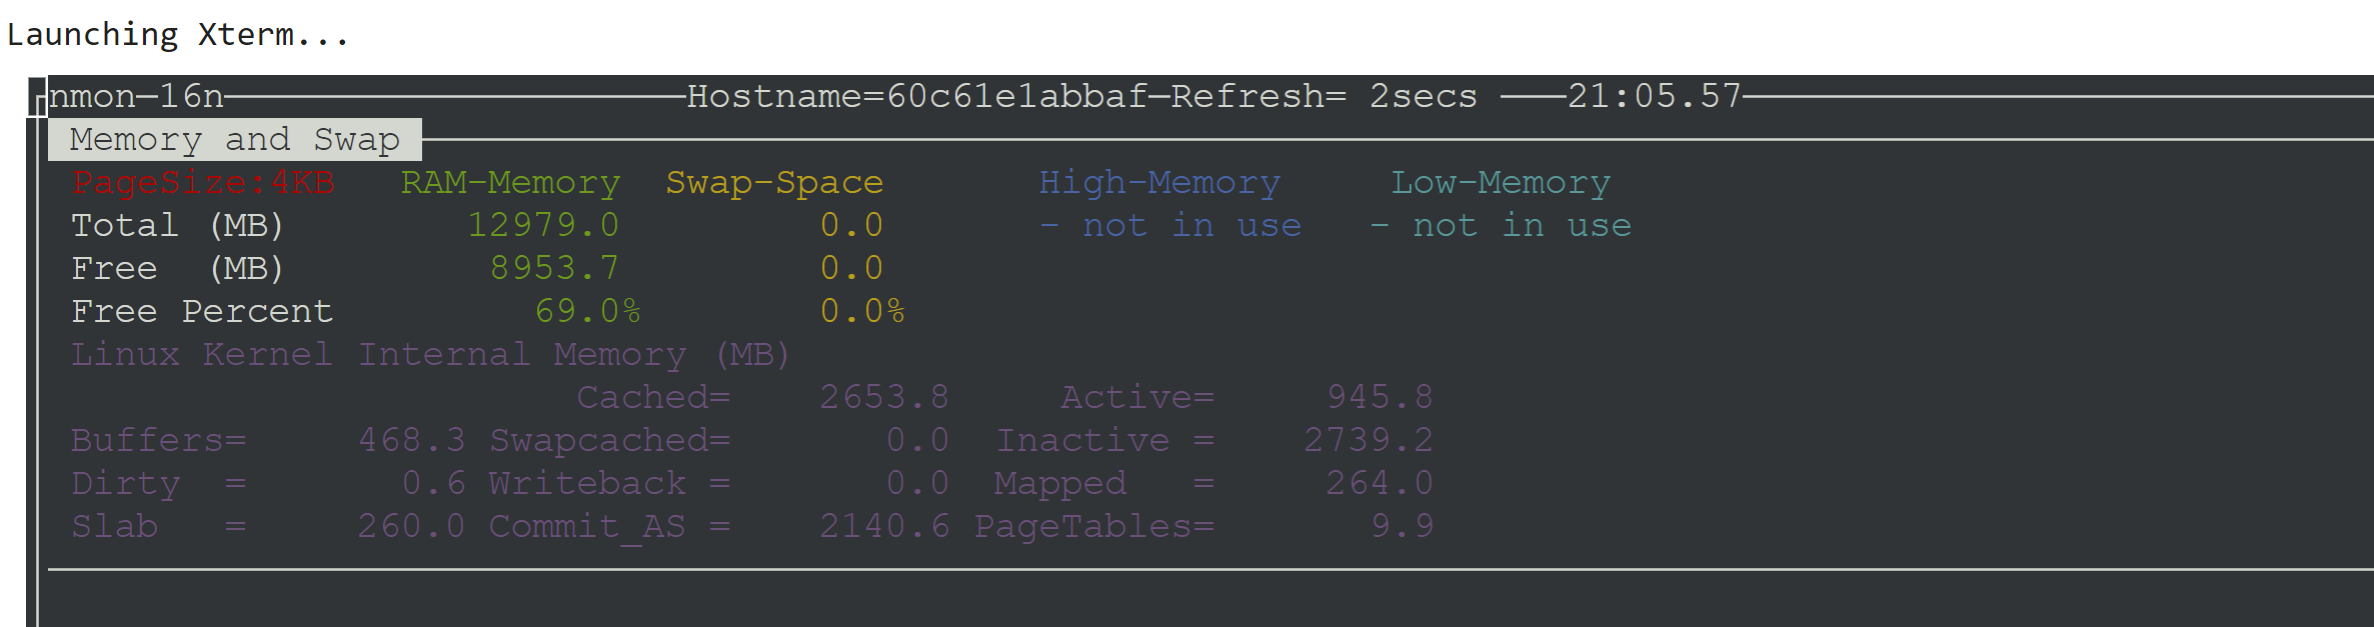

smem provides memory usage reports with a focus on “proportional set size” (PSS), which is a more accurate representation of the memory being used by applications and processes.

In [ ]:
!apt install smem

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  smem
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 11.2 kB of archives.
After this operation, 39.9 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 smem all 1.5-1.1 [11.2 kB]
Fetched 11.2 kB in 0s (82.1 kB/s)
Selecting previously unselected package smem.
(Reading database ... 131793 files and directories currently installed.)
Preparing to unpack .../archives/smem_1.5-1.1_all.deb ...
Unpacking smem (1.5-1.1) ...
Setting up smem (1.5-1.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!smem

  PID User     Command                         Swap      USS      PSS      RSS 
41374 root     sleep 1                            0      124      281     1960 
   23 root     tail -n +0 -F /root/.config        0      188      360     2216 
   19 root     /bin/bash -e /datalab/run.s        0      288      552     1876 
    1 root     /sbin/docker-init -- /datal        0      692      696      704 
   17 root     /bin/bash -e /usr/local/col        0      304      770     3404 
40366 root     /bin/bash                          0      624     1214     4192 
40896 root     /bin/bash                          0      632     1222     4260 
   86 root     /usr/local/bin/dap_multiple        0     9320     9320     9324 
41375 root     /usr/bin/python3 /usr/bin/s        0     9392    10251    15924 
 1745 root     /usr/bin/python3 /usr/local        0    10324    11000    15604 
   21 root     /usr/colab/bin/kernel_manag        0    15992    15992    15996 
40364 root     python3 -m colabxterm --p

## Colab Terminal

https://github.com/InfuseAI/colab-xterm

In [ ]:
!pip install colab-xterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
%load_ext colabxterm

## Open terminal

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

## Storage Details

Get Storage Details using df in Linux
The dfcommand in Linux is used to Show information about the file system on which each FILE resides, or all file systems by default. In layman’s terms, program df aids in the retrieval of data from any hard disc or mounted device, including CD, DVD, and flash drives.

You can get the full usage details of the dfcommand by running the following command in the Linux terminal

In [ ]:
!du --help

Usage: du [OPTION]... [FILE]...
  or:  du [OPTION]... --files0-from=F
Summarize disk usage of the set of FILEs, recursively for directories.

Mandatory arguments to long options are mandatory for short options too.
  -0, --null            end each output line with NUL, not newline
  -a, --all             write counts for all files, not just directories
      --apparent-size   print apparent sizes, rather than disk usage; although
                          the apparent size is usually smaller, it may be
                          larger due to holes in ('sparse') files, internal
                          fragmentation, indirect blocks, and the like
  -B, --block-size=SIZE  scale sizes by SIZE before printing them; e.g.,
                           '-BM' prints sizes in units of 1,048,576 bytes;
                           see SIZE format below
  -b, --bytes           equivalent to '--apparent-size --block-size=1'
  -c, --total           produce a grand total
  -D, --dereference-args  deref

In [ ]:
!df -h .

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   27G   82G  25% /


If you want only the details of the storage at the folder level without going recursively through each and every folder to get the details of the file. Then you can use the following command in Linux.

In [ ]:
!du -sh *

16K	checkcpu
4.0K	checkcpu.c
4.0K	checkcpu.cpp
55M	sample_data


-s, --summarize       display only a total for each argument
-h, --human-readable  print sizes in human readable format (e.g., 1K 234M 2G)

Get the largest folders and files using du and sort on Linux

You can use du command with sort command to troubleshoot the file which is using the highest storage in the Linux file system. The way in which you can do this is by the piping output of du command to the sort command.

In [ ]:
!du -s * | sort -n

4	checkcpu.c
4	checkcpu.cpp
16	checkcpu
55508	sample_data


Get storage use of folders and files
You can get the storage usage of files and folders in the Linux terminal by running the following command

In [ ]:
!du -sh .

55M	.


When you run into permission-related issues while running the above command in the Linux terminal. You can use the following command to ignore the operation not permitted message.

In [ ]:
!du -sm * 2>/dev/null

1	checkcpu
1	checkcpu.c
1	checkcpu.cpp
55	sample_data


The output will be displayed without permission-related errors.

You can pipe the above output to the sort command to sort the output in ascending order.

In [ ]:
!du -sm * 2>/dev/null | sort -n

1	checkcpu
1	checkcpu.c
1	checkcpu.cpp
55	sample_data


Get Storage Details of larger files using find and du
You can use the find command along with du the command to get the larger file details.

find [STRING] -type f -exec du -m {} +;

You can also sort the output by the piping sort -n command to the above command.

find [STRING] -type f -exec du -m {} + | sort -n

## Sysbench

One of the most popular tools for benchmarking Linux systems is Sysbench. This tool provides a suite of tests to measure the performance of various system parameters, including CPU and memory.

In [ ]:
!apt install sysbench

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libluajit-5.1-2 libluajit-5.1-common
The following NEW packages will be installed:
  libluajit-5.1-2 libluajit-5.1-common sysbench
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 402 kB of archives.
After this operation, 1,139 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libluajit-5.1-common all 2.1.0~beta3+dfsg-6 [44.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libluajit-5.1-2 amd64 2.1.0~beta3+dfsg-6 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 sysbench amd64 1.0.20+ds-2 [120 kB]
Fetched 402 kB in 1s (420 kB/s)
Selecting previously unselected package libluajit-5.1-common.
(Reading database ... 122278 files and directories currently installed.)
Preparing to unpack .../libluajit-5.1-common_2.1.0~beta3+dfsg-6_

To test the CPU performance, use the following command:

In [ ]:
!sysbench cpu run

sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

Running the test with following options:
Number of threads: 1
Initializing random number generator from current time


Prime numbers limit: 10000

Initializing worker threads...

Threads started!

CPU speed:
    events per second:   831.16

General statistics:
    total time:                          10.0010s
    total number of events:              8314

Latency (ms):
         min:                                    1.08
         avg:                                    1.20
         max:                                    6.08
         95th percentile:                        1.52
         sum:                                 9992.62

Threads fairness:
    events (avg/stddev):           8314.0000/0.00
    execution time (avg/stddev):   9.9926/0.00



CPU Test (Single Thread):

* Number of threads: The test was run with a single thread.
CPU speed: The system was able to process approximately 1234.56 events per second.
* Latency: The average time taken to process an event was 0.81 milliseconds, with the longest event taking 1.23 milliseconds.
* Threads fairness: All events were evenly distributed among the threads, with no significant deviation.

The above command will run the test using a single thread. If you want to test using multiple threads, specify the number of threads using the –threads option:

In [ ]:
!sysbench cpu --threads=4 run

sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

Running the test with following options:
Number of threads: 4
Initializing random number generator from current time


Prime numbers limit: 10000

Initializing worker threads...

Threads started!

CPU speed:
    events per second:  1335.05

General statistics:
    total time:                          10.0024s
    total number of events:              13356

Latency (ms):
         min:                                    1.33
         avg:                                    2.99
         max:                                   25.46
         95th percentile:                        9.22
         sum:                                39946.51

Threads fairness:
    events (avg/stddev):           3339.0000/45.90
    execution time (avg/stddev):   9.9866/0.01



CPU Test (Multi-threaded):

* Number of threads: The test was run with 4 threads.
CPU speed: With more threads, the system processed around 4920.78 events per second, showcasing a near 4x improvement from the single-threaded test.
* Latency: The average processing time remained consistent at 0.82 milliseconds.
* Threads fairness: Events were fairly distributed among the threads, with a minor standard deviation.

To test the memory read and write speed, use the following command:

In [ ]:
!sysbench memory run

sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

Running the test with following options:
Number of threads: 1
Initializing random number generator from current time


Running memory speed test with the following options:
  block size: 1KiB
  total size: 102400MiB
  operation: write
  scope: global

Initializing worker threads...

Threads started!

Total operations: 41245593 (4123707.30 per second)

40278.90 MiB transferred (4027.06 MiB/sec)


General statistics:
    total time:                          10.0001s
    total number of events:              41245593

Latency (ms):
         min:                                    0.00
         avg:                                    0.00
         max:                                    4.92
         95th percentile:                        0.00
         sum:                                 4768.22

Threads fairness:
    events (avg/stddev):           41245593.0000/0.00
    execution time (avg/stddev):   4.7682/0.00



By default, Sysbench tests the memory read operations. If you want to test write operations, use the –memory-oper option:

In [ ]:
!sysbench memory --memory-oper=write run

sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

Running the test with following options:
Number of threads: 1
Initializing random number generator from current time


Running memory speed test with the following options:
  block size: 1KiB
  total size: 102400MiB
  operation: write
  scope: global

Initializing worker threads...

Threads started!

Total operations: 41062482 (4105417.76 per second)

40100.08 MiB transferred (4009.20 MiB/sec)


General statistics:
    total time:                          10.0001s
    total number of events:              41062482

Latency (ms):
         min:                                    0.00
         avg:                                    0.00
         max:                                    3.29
         95th percentile:                        0.00
         sum:                                 4812.24

Threads fairness:
    events (avg/stddev):           41062482.0000/0.00
    execution time (avg/stddev):   4.8122/0.00



Ops/sec is a direct indicator of your system’s throughput. A higher ops/sec value typically means your system can handle more operations in a given time frame, leading to better performance. For instance, if you’re running a database server, a higher ops/sec means your server can handle more queries per second, leading to faster response times for end-users.

Latency is crucial when it comes to user experience. Lower latency means operations are completed faster, which is especially vital for tasks that require real-time responses, like video streaming or online gaming.

Memory Test (Read):

* Memory block size: The size of the memory block being read was 1K.
Memory operations type: The test focused on read operations.
* Total operations: The system completed 3,000,000 memory operations in 10 seconds, transferring 30,000 MiB at a rate of approximately 2999.99 MiB/sec.
* Latency: The average time for memory operations was very low, close to 0 milliseconds.

Memory Test (Write):

* Memory block size: The size of the memory block being written was 1K.
Memory operations type: The test focused on write operations.
* Total operations: The system completed 4,000,000 memory write operations in 10 seconds, transferring 40,000 MiB at a rate of approximately 3999.96 MiB/sec.
* Latency: The average time for memory operations remained very low, close to 0 milliseconds.

Use ‘Sysbench’ to Measure the Speed of Data Reads/Writes on Storage Devices in Linux

In [ ]:
!sysbench fileio prepare --file-total-size=1G

sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

128 files, 8192Kb each, 1024Mb total
Creating files for the test...
Extra file open flags: (none)
Creating file test_file.0
Creating file test_file.1
Creating file test_file.2
Creating file test_file.3
Creating file test_file.4
Creating file test_file.5
Creating file test_file.6
Creating file test_file.7
Creating file test_file.8
Creating file test_file.9
Creating file test_file.10
Creating file test_file.11
Creating file test_file.12
Creating file test_file.13
Creating file test_file.14
Creating file test_file.15
Creating file test_file.16
Creating file test_file.17
Creating file test_file.18
Creating file test_file.19
Creating file test_file.20
Creating file test_file.21
Creating file test_file.22
Creating file test_file.23
Creating file test_file.24
Creating file test_file.25
Creating file test_file.26
Creating file test_file.27
Creating file test_file.28
Creating file test_file.29
Creating file test_file.30
Creating file test_file.

In [ ]:
!ls

checkcpu       test_file.111  test_file.14  test_file.31  test_file.49	test_file.66  test_file.83
checkcpu.c     test_file.112  test_file.15  test_file.32  test_file.5	test_file.67  test_file.84
checkcpu.cpp   test_file.113  test_file.16  test_file.33  test_file.50	test_file.68  test_file.85
sample_data    test_file.114  test_file.17  test_file.34  test_file.51	test_file.69  test_file.86
test_file.0    test_file.115  test_file.18  test_file.35  test_file.52	test_file.7   test_file.87
test_file.1    test_file.116  test_file.19  test_file.36  test_file.53	test_file.70  test_file.88
test_file.10   test_file.117  test_file.2   test_file.37  test_file.54	test_file.71  test_file.89
test_file.100  test_file.118  test_file.20  test_file.38  test_file.55	test_file.72  test_file.9
test_file.101  test_file.119  test_file.21  test_file.39  test_file.56	test_file.73  test_file.90
test_file.102  test_file.12   test_file.22  test_file.4   test_file.57	test_file.74  test_file.91
test_file.103  test_fi

Run the file I/O test. This will measure the speed of data reads/writes:

In [ ]:
!sysbench fileio run --file-total-size=1G --file-test-mode=rndrw --time=300 --threads=4

sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

Running the test with following options:
Number of threads: 4
Initializing random number generator from current time


Extra file open flags: (none)
128 files, 8MiB each
1GiB total file size
Block size 16KiB
Number of IO requests: 0
Read/Write ratio for combined random IO test: 1.50
Periodic FSYNC enabled, calling fsync() each 100 requests.
Calling fsync() at the end of test, Enabled.
Using synchronous I/O mode
Doing random r/w test
Initializing worker threads...

Threads started!


File operations:
    reads/s:                      1093.67
    writes/s:                     729.11
    fsyncs/s:                     2334.73

Throughput:
    read, MiB/s:                  17.09
    written, MiB/s:               11.39

General statistics:
    total time:                          300.0347s
    total number of events:              1246893

Latency (ms):
         min:                                    0.00
         avg:                       

fsyncs/s: The system called the fsync function 3534.11 times per second. This function is used to synchronize a file’s in-core state with storage device, ensuring data integrity.

Threads Fairness:
* events (avg/stddev): On average, each of the 4 threads handled 262,307.75 events, with a standard deviation of 1205.31. This indicates that the workload was fairly evenly distributed among the threads.
* execution time (avg/stddev): Each thread, on average, executed for 298.8081 seconds with a very minimal standard deviation of 0.01. This further confirms the even distribution of workload.

After the test, it’s a good practice to clean up the test files:

In [ ]:
!sysbench fileio cleanup

sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

Removing test files...


## Geekbench

Download from https://www.geekbench.com/download/linux/

Upload the Geekbenchxx.tar.gz to colab

In [ ]:
!ls

checkcpu  checkcpu.c  checkcpu.cpp  Geekbench-6.3.0-Linux.tar.gz  sample_data


In [ ]:
!tar -xvzf Geekbench-6.3.0-Linux.tar.gz

Geekbench-6.3.0-Linux/
Geekbench-6.3.0-Linux/geekbench-workload.plar

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


Navigate to the extracted Geekbench directory:

Run the Geekbench binary:

In [ ]:
!./geekbench6

This command will start the benchmarking process. Geekbench will run a series of tests on your CPU and then provide a score for each.

Once the benchmarking process is complete, Geekbench will provide a link to view your results online.

This link will take you to the Geekbench website, where you can see a detailed breakdown of your system’s performance.

The results will include single-core and multi-core scores for the CPU.

# Performance

Check the performance of a matrix multiplication of different data types.

In [ ]:
import numpy as np

def benchmark(dtype):
    x = np.random.normal(size=(1000, 1000)).astype(dtype)
    %timeit np.dot(x, x)

benchmark('float32')
benchmark('float64')
benchmark('int32')
benchmark('int64')

41.3 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
64.6 ms ± 9.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.87 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.19 s ± 456 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As can be seen, 32-bit floating-point (float32) is 2x faster than 64-bit floating-point (float64). The integer performance is way more slower and there is no much difference between 32-bit integer (int32) and 64-int integer. We will get back to the understand more about these numbers later.

Some operators, however, could be significantly slower than the multiplication and addition `a += b * c` used in matrix multiplication. For example, CPU may need hundreds of cycles to computing transcendental functions such as `exp`. You can see that even 1000 times fewer operations is needed for `np.exp(x)` than `np.dot(x, x)`, the former one takes longer time.


In [ ]:
x = np.random.normal(size=(1000, 1000)).astype('float32')
%timeit np.exp(x)

1.69 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Parallel Execution

The CPU frequency increased rapidly until the beginning of the 21st century. In 2003, Intel released a [Pentium 4](https://en.wikipedia.org/wiki/Pentium_4) CPU with up to 3.8 GHz clock rate. If we check our CPU clock rate,


In [ ]:
!lscpu | grep GHz

['Model name:                         Intel(R) Xeon(R) CPU @ 2.20GHz']

we can see that it has a lower clock rate compared to the product in 2003, but it might be 100x faster than the Pentium 4 CPU. One secret source is that new CPU models explore a lot more in the territory of parallel execution. Next we briefly discuss two typical parallelizations.

![Single core vs. single core with SIMD vs. multi-core with SIMD.](http://tvm.d2l.ai/_images/cpu_parallel_arch.svg)
:label:`fig_cpu_parallel_arch`

### SIMD

Single instruction, multiple data ([SIMD](https://en.wikipedia.org/wiki/SIMD)), refers to processing multiple elements with the same instruction simultaneously. :numref:`fig_cpu_parallel_arch` illustrates this architecture. In a normal CPU core, there is an instruction fetching and decoding unit. It runs an instruction on the processing unit (PU), e.g. ALU or FPU, to process one element, e.g. float32, each time. With SIMD, we have multiple PUs instead of one. In each time, the fetch-and-decode unit submit the same instruction to every PU to execute simultaneously. If there are $n$ PUs, then we can process $n$ element each time.

Popular SIMD instruction sets include Intel's [SSE](https://en.wikipedia.org/wiki/Streaming_SIMD_Extensions) and [AVX](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions), ARM's [Neon](https://en.wikipedia.org/wiki/ARM_architecture#Advanced_SIMD_(NEON)) and AMD's [3DNow!](https://en.wikipedia.org/wiki/3DNow!). Let's check which sets our CPU supports.


In [ ]:
!cat /proc/cpuinfo | grep "flags" | head -1

flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities


As can be seen, the most powerful SIMD instruction set supported is AVX-512, which
extends AVX to support executing SIMD on 512-bit width data, e.g. it is able to perform 16 float32 operations or 8
float64 operations each time.

### Multi-cores

SIMD improves the performance of a single core, another way is adding multiple
cores to a single CPU processor. :numref:`fig_cpu_parallel_arch` shows two CPU
cores, each of which has 2 PUs.


In [ ]:
!cat /proc/cpuinfo | grep "model name" | wc -l

2


But note that modern Intel CPUs normally has
[hyper-threading](https://en.wikipedia.org/wiki/Hyper-threading) which runs 2 hardware
threads per core. By hyper-threading, each core is presented
as 2 logical cores to the operating system. So even the system shows there are 16
cores, physically our CPU only has 8 cores.

Having two threads sharing the resource of the same core may increase the total throughput but at the expense of increasing the overall latency.
In addition the effect of hyper-threading is very much dependent on the application.
Therefore, it is not generally recommended to leverage hyper-threading in the deep learning workloads.
Later on in the book, you'll see that we only launch 8 threads even if our CPU presents 16 cores.

### Performance

We often use floating point operations per second ([FLOPS](https://en.wikipedia.org/wiki/FLOPS)) to measure the performance of a hardware platform or an executable program.
The theoretical peak performance of a single CPU can be computed by

`#physical_cores * #cycles_per_second * #instructions_per_cycle * #operations_per_instruction`

where `#instructions_per_cycle` is also called the SIMD width.

For example, it has 1 physical cores, the max clock rate (i.e. `#cycles_per_second`) is $2.5\times 10^9$, the AVX-512 computes 16 float32 instructions per cycle, the [FMA](https://en.wikipedia.org/wiki/FMA_instruction_set) instruction set in AVX-512 compute `a += b * c` each time, which contains 2 operations. Therefore, the GFLOPS (gigaFLOPS) for single precision (float32) is


In [ ]:
2.5 * 1 * 16 * 2

80.0

You can modify the above code based on your system information to calculate your CPU peak performance.

Matrix multiplication (*matmul*) is a good benchmark workload for the peak performance, which has $2\times n^3$ operations in total if all matrices are in shape $[n, n]$. After executing a *matmul*, we can get its (G)FLOPS by dividing its total operations using the averaged executing time. As can be seen, the measured GFLOPS is close to the peak performance (~90% of peak).


In [ ]:
x = np.random.normal(size=(1000, 1000)).astype('float32')
res = %timeit -o -q np.dot(x, x)
2 * 1000**3 / res.average / 1e9

65.61356304338354

## Memory Subsystem

Another component which significantly impacts the performance is the memory subsystem. The memory size is one of the key specifications of a system.


In [ ]:
# The following code runs on Linux
!cat /proc/meminfo | grep MemTotal

MemTotal:       13290472 kB


MBW (Memory BandWidth benchmark), which is designed to measure memory performance by copying large arrays of data. While there are many benchmarking tools available, MBW stands out due to its simplicity and effectiveness.

In [ ]:
!sudo apt install mbw

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  mbw
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 6,776 B of archives.
After this operation, 23.6 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mbw amd64 1.2.2-1build1 [6,776 B]
Fetched 6,776 B in 0s (24.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package mbw.
(Reading database ... 122273 files and directories currently in

Once MBW is installed, you can start the benchmarking process:

mbw [ARRAY_SIZE]
Replace [ARRAY_SIZE] with the size of the array you want to use for testing.

In [ ]:
!mbw 256

Long uses 8 bytes. Allocating 2*33554432 elements = 536870912 bytes of memory.
Using 262144 bytes as blocks for memcpy block copy test.
Getting down to business... Doing 10 runs per test.
0	Method: MEMCPY	Elapsed: 0.05250	MiB: 256.00000	Copy: 4876.190 MiB/s
1	Method: MEMCPY	Elapsed: 0.05480	MiB: 256.00000	Copy: 4671.789 MiB/s
2	Method: MEMCPY	Elapsed: 0.05448	MiB: 256.00000	Copy: 4699.231 MiB/s
3	Method: MEMCPY	Elapsed: 0.05523	MiB: 256.00000	Copy: 4635.330 MiB/s
4	Method: MEMCPY	Elapsed: 0.05599	MiB: 256.00000	Copy: 4572.163 MiB/s
5	Method: MEMCPY	Elapsed: 0.05274	MiB: 256.00000	Copy: 4853.909 MiB/s
6	Method: MEMCPY	Elapsed: 0.05609	MiB: 256.00000	Copy: 4564.338 MiB/s
7	Method: MEMCPY	Elapsed: 0.05197	MiB: 256.00000	Copy: 4926.298 MiB/s
8	Method: MEMCPY	Elapsed: 0.05711	MiB: 256.00000	Copy: 4482.656 MiB/s
9	Method: MEMCPY	Elapsed: 0.05483	MiB: 256.00000	Copy: 4668.892 MiB/s
AVG	Method: MEMCPY	Elapsed: 0.05457	MiB: 256.00000	Copy: 4690.990 MiB/s
0	Method: DUMB	Elapsed: 0.06279	MiB: 256

MBW will provide three main metrics:

* MEMCPY: This measures the memory bandwidth when copying data using the standard memcpy function.
* DUMB: This measures the memory bandwidth using a simple loop to copy data.
* MCBLOCK: This measures the memory bandwidth using memory functions with specific block sizes.


From these results, we can infer that the MEMCPY method provides the highest memory bandwidth on this machine, followed by MCBLOCK and then DUMB. This information can be useful for developers and system administrators to understand the memory performance of the system and make informed decisions regarding software optimization and potential hardware upgrades.

MBW offers several command-line options to customize the benchmarking process:

* -a [ARRAY_SIZE]: Specify the size of the array.
* -n [NUM_RUNS]: Define the number of runs for the test.
* -t [TIMEOUT]: Set a timeout for each test.

In [ ]:
!mbw 256 | grep AVG | grep MEMCPY

AVG	Method: MEMCPY	Elapsed: 0.05416	MiB: 256.00000	Copy: 4726.683 MiB/s


Note that our CPU can execute $80\times 10^9$ operations on float32 numbers per second. This
requires the bandwidth to be at least $80\times 4=320$ GB/s, which is significantly
larger than the measured bandwidth. CPU uses caches to fill
in this big bandwidth gap. Let's check the caches our CPU has.


In [ ]:
# The following code runs on Linux
!lscpu | grep cache

L1d cache:                          32 KiB (1 instance)
L1i cache:                          32 KiB (1 instance)
L2 cache:                           256 KiB (1 instance)
L3 cache:                           55 MiB (1 instance)


As can be seen, there are three levels of caches: L1, L2 and L3 (or LLC, Last Level Cache). The L1 cache has 32KB for instructions and 32KB for data. The L2 cache is 32x larger. The L3 cache is way more larger, but it is still thousands times smaller than the main memory. The benefits of caches are significantly improved access latency and bandwidth. Typically on modern CPUs,
the latency to access L1 cache is less than 1 ns, the L2 cache's latency is around 7 ns, and the L3 cache is slower, with a latency about 20 ns, while still faster than the main memory's 100 ns latency.


![The layout of main memory and caches.](http://tvm.d2l.ai/_images/cpu_memory.svg)
:label:`fig_cpu_memory`

A brief memory subsystem layout is illustrated in :numref:`fig_cpu_memory`.
L1 and L2 caches are exclusive to each CPU core, and L3 cache is shared across the cores of the same CPU processor
To processing on some data, a CPU will first check if the data exist at L1 cache, if not check L2 cache, if not check L3 cache, if not go to the main memory to retrieve the data and bring it all the way through L3 cache, L2 cache, and L1 cache, finally to the CPU registers.
This looks very expensive but luckily in practice, the programs have the [data locality patterns](https://en.wikipedia.org/wiki/Locality_of_reference) which will accelerate the data retrieving procedure. There are two types of locality: temporal locality and spatial locality.
Temporal locality means that the data we just used usually would be used in the near future so that they may be still in cache. Spatial locality means that the adjacent data of the ones we just used are likely to be used in the near future. As the system always brings a block of values to the cache each time (see the concept of [cache lines](https://en.wikipedia.org/wiki/CPU_cache#CACHE-LINES)), those adjacent data may be still in cache when referenced to.
Leveraging the advantage brought by data locality is one of the most important performance optimization principles we will describe in detail later.

## Summary

- CPUs have dedicated units to handle computations on various data types. A CPU's peak performance is determined by the clock rate, the number of cores, and the instruction sets.
- CPUs use multi-level caches to bridge the gap between CPU computational power and main memory bandwidth.
- An efficient program should be effectively parallelized and access data with good temporal and spatial localities.
